In [192]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Kobe Shot Selection
In this dataset, provided by [Kaggle](https://www.kaggle.com/c/kobe-bryant-shot-selection) we have a record of every shot that Kobe Bryant took in his long career with the LA Lakers. Details about the nature of each shot are included such as location on the court, shot type, and shot zone area. Time information is also included to contextualize the shot such as the time left in the game, and date. 

In the competition, the test set is represented by rows with a missing *shot_made_flag*. Since we are just doing some visualizations here, we will drop these rows.

In [193]:
df = pd.read_csv('Data/data.csv')
df.dropna(inplace=True)
df.iloc[0]

action_type                    Jump Shot
combined_shot_type             Jump Shot
game_event_id                         12
game_id                         20000012
lat                              34.0443
loc_x                               -157
loc_y                                  0
lon                             -118.427
minutes_remaining                     10
period                                 1
playoffs                               0
season                           2000-01
seconds_remaining                     22
shot_distance                         15
shot_made_flag                         0
shot_type                 2PT Field Goal
shot_zone_area              Left Side(L)
shot_zone_basic                Mid-Range
shot_zone_range                 8-16 ft.
team_id                       1610612747
team_name             Los Angeles Lakers
game_date                     2000-10-31
matchup                        LAL @ POR
opponent                             POR
shot_id         

## Feature Extraction
We are given a string containg match up information.

In [194]:
df['matchup'].unique()[0:10]

array(['LAL @ POR', 'LAL vs. UTA', 'LAL @ VAN', 'LAL vs. LAC', 'LAL @ HOU',
       'LAL @ SAS', 'LAL vs. HOU', 'LAL vs. DEN', 'LAL @ SAC', 'LAL @ DEN'], dtype=object)

Away games are designated by an '&' and home games by a 'vs.'. Using this we can make a *home_game* column.

In [195]:
df['home_game'] = df['matchup'].apply(lambda x: 'Home' if '@' in x else 'Away')

## Shot Location and Accuracy
We can see if Kobe had any favourite shot locations by plotting a 2D histogram of the location data. For fun, we will overly this information on a court image.

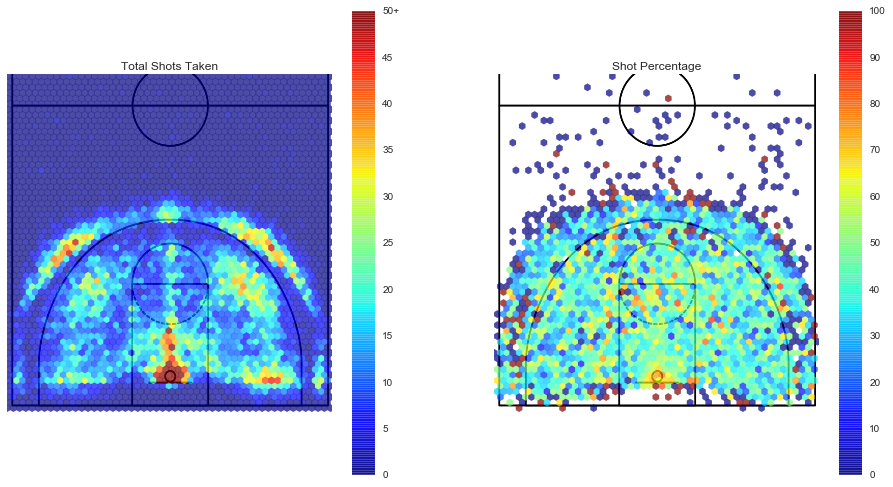

In [196]:
court_ratio = 520/500
fig, axs = plt.subplots(1, 2, figsize=(8*2, 8*court_ratio))
df[(df['loc_y'] <= 470)].plot.hexbin(x='loc_x', y='loc_y',
                                     gridsize=52, ax=axs[0], grid=False, 
                                     alpha=0.7, vmax=50, cmap=plt.cm.jet, colorbar=True,
                                     title='Total Shots Taken', xticks=[], yticks=[], use_index=False)
df[(df['loc_y'] <= 470)].plot.hexbin(x='loc_x', y='loc_y', C='shot_made_flag',
                                     reduce_C_function=lambda x: sum(x)/len(x) * 100,
                                     gridsize=52, ax=axs[1], grid=False, 
                                     alpha=0.7, cmap=plt.cm.jet, colorbar=True,
                                     title='Shot Percentage', xticks=[], yticks=[])
for ax in axs:
    ax.set_xlim([-250, 250]); ax.set_ylim([-50, 470])
    ax.imshow(mpimg.imread('court.png'), extent=[-250, 252, -50, 890])
    ax.set_xlabel(''); ax.set_ylabel('')
cb1 = fig.get_axes()[2]
cb1_cm_labels = cb1.get_yticklabels()
cb1_cm_labels[-1].set_text(cb1_cm_labels[-1].get_text() + '+')
cb1.set_yticklabels(cb1_cm_labels)
plt.show()

## Long Term Time Trends

Grouping by season, we can pull out some long term trends in Kobes career. Starting with his shooting percentage we see that he hit his peak around 2007 before starting to dwindle. Seems that Kobe was also a great Away team shooter.

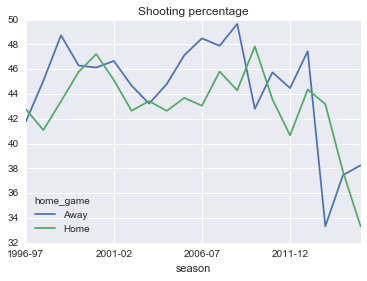

In [197]:
season_home_grouped = df.groupby(['season', 'home_game'])
season_home_grouped['shot_made_flag'].apply(lambda x: 
                                            sum(x)/len(x) * 100).unstack().plot(title='Shooting percentage')

Another question is whether Kobe's play style changed as he aged. We can get a glimpse into this by looking at the distribution of shot type over time. This shows that he did seem to become more of a shooter then driving to the net with an increase in jump shot proportions and a decrease in layups and dunks.

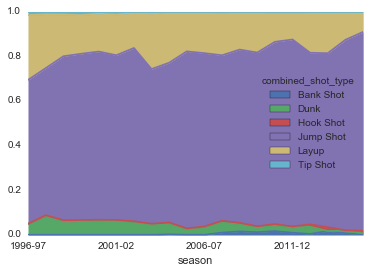

In [198]:
season_shots = df.groupby(['season', 'combined_shot_type']).size().unstack()
season_shots.divide(season_shots.sum(axis=1), axis=0).plot(kind='area', stacked=True)

Inside the *shot_type* the first character is a number corresponding to the point value of each shot. We can pull this out into its own column and look at the the distribution of average points as well as its trend over time.

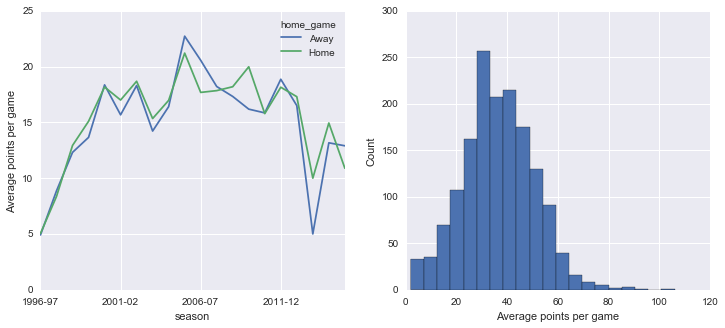

In [199]:
df['points'] = df['shot_type'].apply(lambda x: int(x[0]))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df.groupby(['season', 'home_game']).apply(lambda x: 
                                          sum(x['shot_made_flag'] * x['points']) / 
                                          len(x['game_id'].unique())).unstack().plot(ax=axs[0])
df.groupby(['game_id'])['points'].sum().hist(bins=20, ax=axs[1])
axs[0].set_ylabel('Average points per game'); axs[1].set_xlabel('Average points per game'); axs[1].set_ylabel('Count')

# Momentum
A big thing in basketball is momentum and being 'in the zone'. This is especially evident with star players as when they start to score and shoot well, their team will push the ball towards them to let them take even more shots.

We can pull this out by looking at the second half performance as a function of the first half performance. We would expect a hot first half to lead to a hot second half. For conveniance, we will make a *half* column from the *period* column that already exists. We will ignore overtime periods as well to avoid positively skewing the second half scores.

In [201]:
df['half'] = df['period'].apply(lambda x: 'second' if x >2 else 'first')
df_no_overtime = df[df['period'] <= 4]
df_no_overtime[['period', 'half']].head()

,period,half
1,1,first
2,1,first
3,1,first
4,2,first
5,3,second


In [202]:
game_half_grouped = df_no_overtime.groupby(['game_id', 'half'])
half_points = game_half_grouped.apply(lambda x: sum(x['shot_made_flag'] * x['points'])).unstack().fillna(0)
half_acc = game_half_grouped.apply(lambda x: x['shot_made_flag'].mean() * 100).unstack()

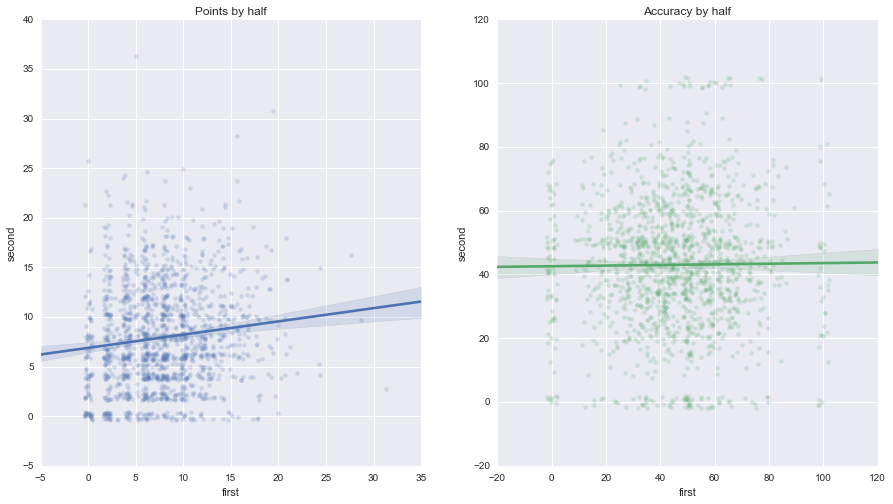

In [203]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.regplot(x='first', y='second', data=half_points, x_jitter=.4, y_jitter=.4, ax=axs[0], scatter_kws={'alpha': 0.2})
sns.regplot(x='first', y='second', data=half_acc, x_jitter=2, y_jitter=2, ax=axs[1], scatter_kws={'alpha': 0.2})
axs[0].set_title('Points by half'); axs[1].set_title('Accuracy by half')

In [211]:
game_grouped = df.groupby('game_id')
df['streak'] = game_grouped['shot_made_flag'].apply(lambda df: df.rolling(10).mean())
df.sort_values('game_id')['streak']

1        NaN
9        NaN
8        NaN
6        NaN
10       NaN
4        NaN
3        NaN
2        NaN
5        NaN
23       0.4
31       0.4
30       0.4
29       0.3
28       0.3
27       0.4
25       0.4
24       0.4
22       0.4
26       0.4
20       NaN
18       NaN
17       NaN
15       NaN
14       NaN
13       NaN
12       NaN
11       NaN
21       NaN
51       0.5
50       0.6
        ... 
30656    NaN
30654    NaN
30653    NaN
30652    NaN
30651    NaN
30650    NaN
30658    NaN
30685    0.3
30687    0.2
30688    0.3
30692    0.2
30690    0.2
30691    0.2
30684    0.3
30694    0.2
30689    0.2
30683    0.4
30677    NaN
30679    0.3
30678    NaN
30676    NaN
30675    NaN
30674    NaN
30673    NaN
30672    NaN
30671    NaN
30670    NaN
30695    0.2
30681    0.4
30696    0.2
Name: streak, dtype: float64

In [208]:
df.groupby(['streak'])['shot_made_flag'].mean()

streak
0.0    0.000000
0.1    0.101961
0.2    0.189798
0.3    0.261631
0.4    0.381674
0.5    0.466292
0.6    0.610671
0.7    0.709452
0.8    0.783465
0.9    0.843137
1.0    1.000000
Name: shot_made_flag, dtype: float64